In [1]:
import fitsio
import sxdes
from ngmix.prepsfmom import PGaussMom
from ngmix import Observation, DiagonalJacobian
from ngmix.medsreaders import NGMixMEDS
import meds
import numpy as np

import proplot as pplt

In [3]:
m = NGMixMEDS("DES0000+0209_r5763p01_r_pizza-cutter-slices.fits.fz")

In [14]:
def _get_pgauss(x, y, nse, psf, jac):
    md = nse.shape[0]
    xc = int(x + 0.5)
    yc = int(y + 0.5)
    h = 21
    dim = h*2 + 1
    xl = xc - h
    yl = yc - h
    
    if (
        (xl < 0) 
        or (yl < 0) 
        or (xl + dim >= md) 
        or (yl + dim >= md)
    ):
        return None
    
    img = nse[yl:yl+dim, xl:xl+dim]
    jacobian = jac.copy()
    jacobian.set_cen(row=y-yl, col=x-xl)
    var = np.std(nse)**2
    obs = Observation(
        image=img,
        weight=np.ones_like(img)/var,
        jacobian=jacobian,
        psf=psf,
    )
    
    try:
        return PGaussMom(1.75).go(obs)
    except Exception as e:
        print(e)
        return None

In [18]:
import tqdm

all_res = []
with tqdm.trange(m.size, ncols=79) as titr:
    for ind in titr:
        if m["ncutout"][ind] > 0:
            nse = m.get_cutout(ind, 0, type="noise")
            obs = m.get_obs(ind, 0)
            cat, _ = sxdes.run_sep(nse, np.std(nse))
            for i in range(cat.shape[0]):
                res = _get_pgauss(cat["x"][i], cat["y"][i], nse, obs.psf, obs.jacobian)
                if res is not None and np.isfinite(res["T"]) and np.isfinite(res["T_err"]):
                    all_res.append(res)
                    titr.set_description("%d meas" % len(all_res))
            if len(all_res) > 100000:
                break

21659 meas: 100%|██████████████████████████| 9801/9801 [06:11<00:00, 26.41it/s]


Text(0, 0.5, 'T')

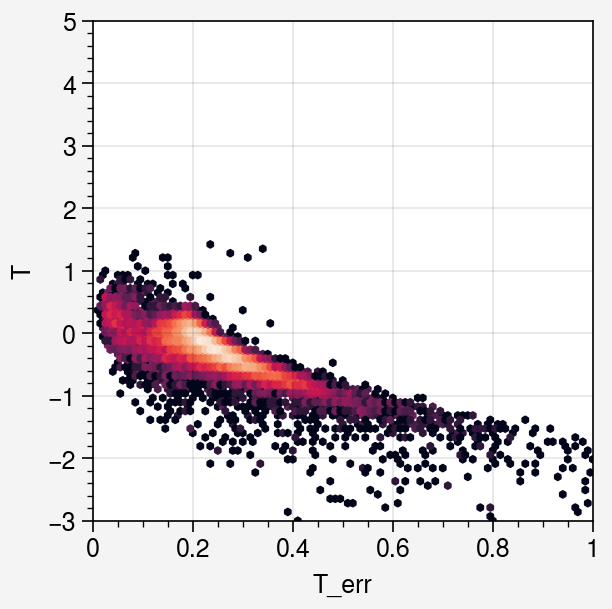

In [19]:
fig, axs = pplt.subplots()

s2n_cut = 1
t = np.array([r["T"] for r in all_res if r["s2n"] > s2n_cut])
terr = np.array([r["T_err"] for r in all_res if r["s2n"] > s2n_cut])

axs.hexbin(
    terr, 
    t, 
    norm="log", 
    cmap="rocket", 
    extent=(0.0, 1.0, -3, 5),
)
axs.set_xlim(0, 1)
axs.set_ylim(-3, 5)
axs.set_xlabel("T_err")
axs.set_ylabel("T")